Epoch [1/3], Step [100/600], Loss: 1.2454
Epoch [1/3], Step [200/600], Loss: 1.1994
Epoch [1/3], Step [300/600], Loss: 1.0986
Epoch [1/3], Step [400/600], Loss: 1.0568
Epoch [1/3], Step [500/600], Loss: 1.0733
Epoch [1/3], Step [600/600], Loss: 0.9812
Epoch [2/3], Step [100/600], Loss: 1.0850
Epoch [2/3], Step [200/600], Loss: 1.0584
Epoch [2/3], Step [300/600], Loss: 1.0208
Epoch [2/3], Step [400/600], Loss: 1.0899
Epoch [2/3], Step [500/600], Loss: 0.8715
Epoch [2/3], Step [600/600], Loss: 0.9433
Epoch [3/3], Step [100/600], Loss: 0.9709
Epoch [3/3], Step [200/600], Loss: 1.0059
Epoch [3/3], Step [300/600], Loss: 0.9740
Epoch [3/3], Step [400/600], Loss: 0.9848
Epoch [3/3], Step [500/600], Loss: 1.0988
Epoch [3/3], Step [600/600], Loss: 0.9451


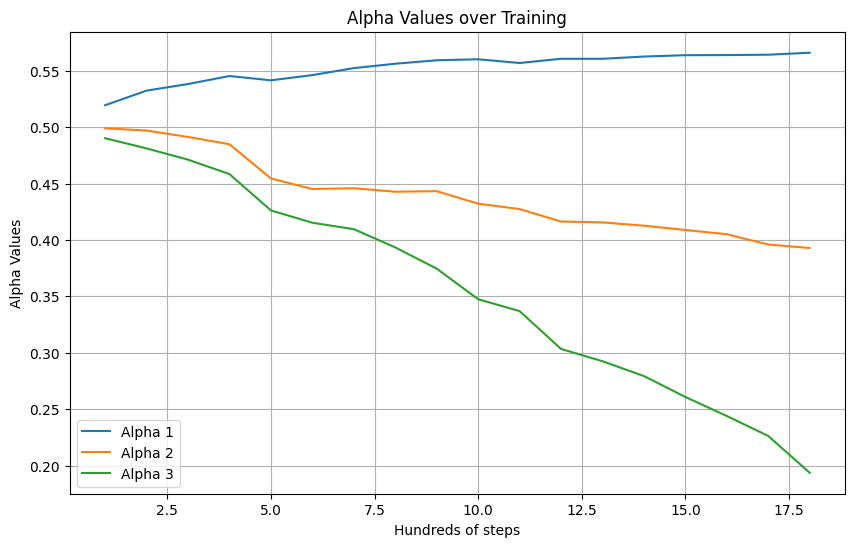

Model Accuracy on the 10000 test images: 89.53 %
alpha1 =  0.5660797953605652 alpha2 =  0.3929154574871063 alpha3 =  0.19362784922122955


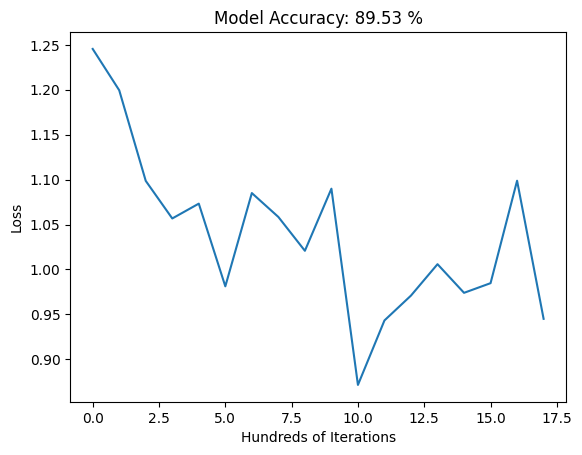

Predicted Label for Image below is Ankle Boot


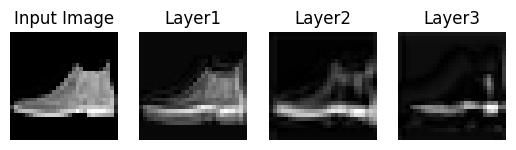

Predicted Label for Image below is Pullover


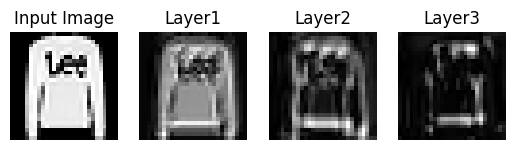

Predicted Label for Image below is Trouser


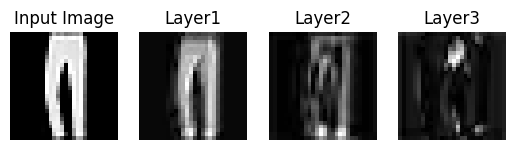

Predicted Label for Image below is Trouser


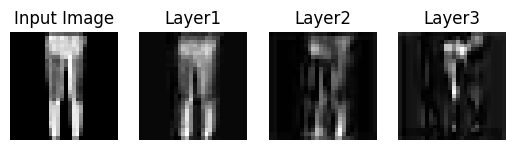

Predicted Label for Image below is Shirt


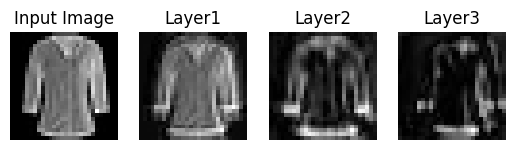

Predicted Label for Image below is Trouser


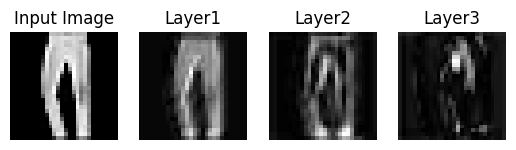

Predicted Label for Image below is Coat


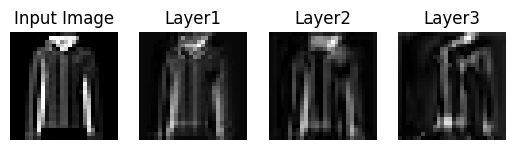

Predicted Label for Image below is Shirt


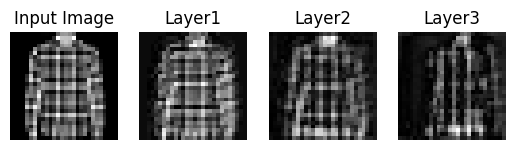

Predicted Label for Image below is Sandal


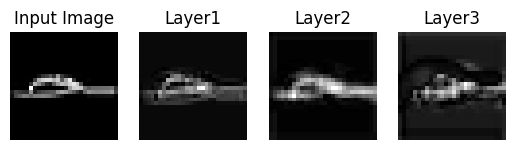

Predicted Label for Image below is Sneaker


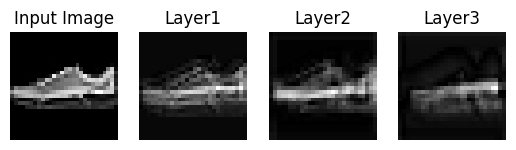

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

# config device
device = torch.device('cpu')

for Lambda in [0.1, 0.3, 0.5, 0.7, 0.9, 2, 5]:
    # hyper-parameters
    num_epochs = 3
    num_classes = 10
    batch_size = 100
    learning_rate = 0.001

    #alphas1/2/3 is 0 iff linear, 1 iff ReLU
    alpha1=0.5
    alpha2=0.5
    alpha3=0.5

    #list for tracking alpha values
    alpha_history = []
    #Storing loss
    losses = []

    # FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(
        root='../../data/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='../../data/',
        train=False,
        transform=transforms.ToTensor()
    )

    # Data load
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
    )


    class AlphaReLU(nn.Module):
        def __init__(self, alpha=0.5):
            super(AlphaReLU, self).__init__()
            self.alpha = nn.Parameter(torch.tensor(alpha))

        def forward(self, x):
            return torch.relu(x) + self.alpha * torch.relu(-x)

    # Customized AlphaCrossEntropyLoss
    class AlphaCrossEntropyLoss(nn.Module):
        def __init__(self, alpha1, alpha2, alpha3, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean', inplace=False):
            super(AlphaCrossEntropyLoss, self).__init__()
            self.loss_function = nn.CrossEntropyLoss(weight, size_average, ignore_index, reduce, reduction)
            self.alpha1 = alpha1
            self.alpha2 = alpha2
            self.alpha3 = alpha3

        def forward(self, outputs, targets):
            loss = self.loss_function(outputs, targets) + Lambda*(abs(self.alpha1) + abs(self.alpha2) + abs(self.alpha3))
            return loss

    class ConvNet(nn.Module):
        def __init__(self, num_classes=10, alpha1=0.5, alpha2=0.5, alpha3=0.5):
            super(ConvNet, self).__init__()

            self.layer1 = nn.Sequential(
                nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
                AlphaReLU(alpha1),
            )
            self.layer2 = nn.Sequential(
                nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
                AlphaReLU(alpha2),
            )
            self.layer3 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                AlphaReLU(alpha3),
            )
            self.fc = nn.Linear(25088, num_classes)

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = out.view(out.size(0), -1)
            #print(out.shape)
            out = self.fc(out)
            return out


    model = ConvNet(num_classes, alpha1=alpha1, alpha2=alpha2, alpha3=alpha3).to(device)

    criterion = AlphaCrossEntropyLoss(alpha1=alpha1, alpha2=alpha2, alpha3=alpha3)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)


    # Train
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 100 == 0:
                losses.append(loss.item())
                alphas = {
                    "alpha1": model.layer1[1].alpha.item(),
                    "alpha2": model.layer2[1].alpha.item(),
                    "alpha3": model.layer3[1].alpha.item()
                            }
                alpha_history.append(alphas)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    #Plot alpha history
    # Access alpha values for each epoch
    alpha1_values = [entry["alpha1"] for entry in alpha_history]
    alpha2_values = [entry["alpha2"] for entry in alpha_history]
    alpha3_values = [entry["alpha3"] for entry in alpha_history]

    epochs = range(1, len(alpha_history) + 1)

    # Plotting alpha values over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, alpha1_values, label='Alpha 1')
    plt.plot(epochs, alpha2_values, label='Alpha 2')
    plt.plot(epochs, alpha3_values, label='Alpha 3')

    plt.title('Alpha Values over Training')
    plt.xlabel('Hundreds of steps')
    plt.ylabel('Alpha Values')
    plt.legend()
    plt.grid(True)
    plt.savefig('Alphas_Values_over_training_{:.1f}.png'.format(Lambda))
    plt.show()

    from torchvision import utils
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))
        print('alpha1 = ', alpha1_values[-1], 'alpha2 = ', alpha2_values[-1], 'alpha3 = ', alpha3_values[-1])

    #Plot loss
    plt.plot(losses)
    plt.title('Model Accuracy: {} %'.format(100 * correct / total))
    plt.xlabel('Hundreds of Iterations')
    plt.ylabel('Loss')
    # Save the plot as a PNG file
    plt.savefig('training_loss_plot_alpha_{:.1f}.png'.format(Lambda))
    plt.show()

    names= ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'] 
    # Plot feature map (to adjust based on number of layer)

    with torch.no_grad():
        for i in range(10):  # Iterate through 10 images
            images, labels = iter(test_loader).__next__()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print('Predicted Label for Image below is', names[predicted[i]])

            image_list = [
                images[i][0].cpu().numpy(),
                model.layer1(images)[i][0].cpu().numpy(),
                model.layer2(model.layer1(images))[i][0].cpu().numpy(),
                model.layer3(model.layer2(model.layer1(images)))[i][0].cpu().numpy()
            ]

            # Display feature maps
            for j, feature_map in enumerate(image_list):
                plt.subplot(1, len(image_list), j + 1)
                plt.imshow(feature_map, cmap='gray')  # Display grayscale image
                if(j==0):
                    plt.title('Input Image')
                if(j>0): 
                    plt.title(f'Layer{j}')
                plt.axis('off')
            plt.savefig('Feature_map_alpha_{}_{:.1f}.png'.format(i,Lambda))
            plt.show()